In [5]:
!pip install opendatasets

In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

# Data Collection, Preprocessing

#####  Load data into tf.Dataset

In [6]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "RiceDiseases",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE    
)

Found 2254 files belonging to 5 classes.


In [8]:
class_names = dataset.class_names
class_names

['Bacterial_Leaf_Blight',
 'Brown_Spot',
 'Healthy',
 'Leaf_Scald',
 'Narrow_Brown_Spot']

In [9]:
len(dataset) #length of the dataset

71

In [10]:
for image_batch, label_batch in dataset.take(1):
    plt.show()
    print("Image batch size", image_batch.shape)
    print("Label batch", label_batch.numpy())

Image batch size (32, 256, 256, 3)
Label batch [1 4 3 0 3 2 3 2 3 4 3 3 1 3 1 2 1 1 4 2 1 2 3 4 3 3 1 3 1 3 4 0]


#### Data visualization

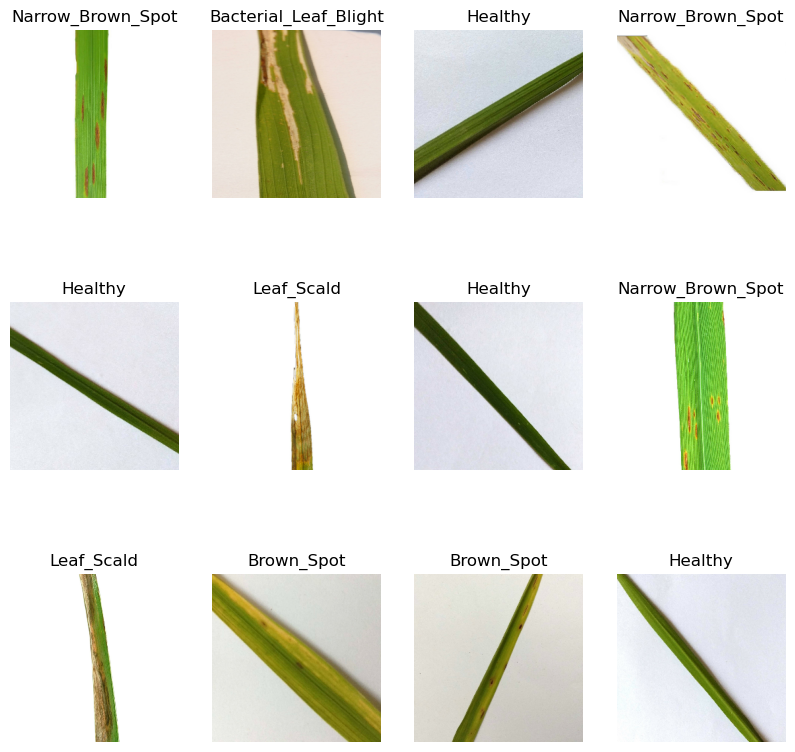

In [11]:
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

#### Train test split

In [12]:
# 80% ==> training
# 20% ==> 10% validation, 10% test

In [13]:
# ////...........Way 1.................////

In [14]:
train_size =0.8
len(dataset)* train_size

56.800000000000004

In [15]:
train_ds =  dataset.take(23)
len(train_ds)

23

In [16]:
test_ds = dataset.skip(23) #arr[:54]
len(test_ds)

48

In [17]:
val_size = 0.1
len(dataset)*val_size

7.1000000000000005

In [18]:
val_ds = test_ds.take(2)
len(val_ds)

2

In [19]:
test_ds = test_ds.skip(2)
len(test_ds)

46

In [20]:
# ////...........Way 2.................////

In [21]:
def get_dataset_partition_tf(ds, train_split = 0.8 , val_split = 0.1, test_split = 0.1, shuffle= True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(train_split * ds_size)
    
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [22]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset,)

In [23]:
len(train_ds)

56

In [24]:
len(val_ds)

7

In [25]:
len(test_ds)

8

In [26]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

# Data Augumentation

In [27]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE), #Resize the images
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [28]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

# Build the model

In [29]:
# 01. Fisrt define the deep leaning NN architecture 

In [30]:
# input_shape = (BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
# n_classes = 5

# model = models.Sequential([
#     resize_and_rescale,
#     data_augmentation,
#     layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64 ,kernel_size = (3,3),  activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64 ,kernel_size = (3,3),  activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64, (3,3), activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64, (3,3), activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64, (3,3), activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Flatten(),
#     layers.Dense(64, activation = 'relu'),
#     layers.Dense(n_classes, activation = 'softmax'), #normalize the probebilit of the class
# ])

# model.build(input_shape = input_shape)

In [31]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 20

def create_model():
    model = models.Sequential([
        layers.InputLayer(input_shape=input_shape),
        layers.Conv2D(32, kernel_size = (3,3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(n_classes, activation='softmax'),
    ])
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
     )
    
    return model

In [34]:
model = create_model()

In [35]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 64)       

In [102]:
# 02. Then compile

In [103]:
# model.compile(
#     optimizer = 'adam',
#     loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
#     metrics = ['accuracy'] #Track the training process
# )

In [104]:
# 03. Train the network

In [36]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
56/56 [==============================] - 45s 691ms/step - loss: 2.4715 - accuracy: 0.4030 - val_loss: 0.9210 - val_accuracy: 0.6456
Epoch 2/50
56/56 [==============================] - 37s 655ms/step - loss: 0.8696 - accuracy: 0.6646 - val_loss: 0.7180 - val_accuracy: 0.7427
Epoch 3/50
56/56 [==============================] - 38s 672ms/step - loss: 0.7970 - accuracy: 0.6933 - val_loss: 0.7879 - val_accuracy: 0.6796
Epoch 4/50
56/56 [==============================] - 47s 837ms/step - loss: 0.6196 - accuracy: 0.7717 - val_loss: 0.6438 - val_accuracy: 0.7427
Epoch 5/50
56/56 [==============================] - 43s 764ms/step - loss: 0.5347 - accuracy: 0.8168 - val_loss: 0.7484 - val_accuracy: 0.7233
Epoch 6/50
56/56 [==============================] - 44s 785ms/step - loss: 0.4521 - accuracy: 0.8422 - val_loss: 0.4458 - val_accuracy: 0.8495
Epoch 7/50
56/56 [==============================] - 39s 690ms/step - loss: 0.4337 - accuracy: 0.8563 - val_loss: 0.3684 - val_accuracy: 0.8641

####  Plot training history on graph

In [37]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 8s 199ms/step - loss: 0.0332 - accuracy: 0.9958


In [38]:
scores

[0.033234450966119766, 0.9957982897758484]

In [39]:
history


In [40]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 56}

In [41]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [42]:
history.history['accuracy']

[0.4030439555644989,
 0.6645997762680054,
 0.6933483481407166,
 0.7717023491859436,
 0.816798210144043,
 0.8421645760536194,
 0.8562570214271545,
 0.8714768886566162,
 0.8816234469413757,
 0.8804960250854492,
 0.9289740920066833,
 0.9487034678459167,
 0.9526493549346924,
 0.9627959132194519,
 0.9379932284355164,
 0.9695603251457214,
 0.8979706764221191,
 0.9554678797721863,
 0.9729425311088562,
 0.9921082258224487,
 0.994363009929657,
 0.9859075546264648,
 0.9898534417152405,
 0.9464486837387085,
 0.9594137668609619,
 0.9746335744857788,
 0.9740698933601379,
 0.9695603251457214,
 0.9875986576080322,
 0.9746335744857788,
 0.994363009929657,
 0.9554678797721863,
 0.979706883430481,
 0.994363009929657,
 0.9921082258224487,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [43]:
len(history.history['accuracy'])

50

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

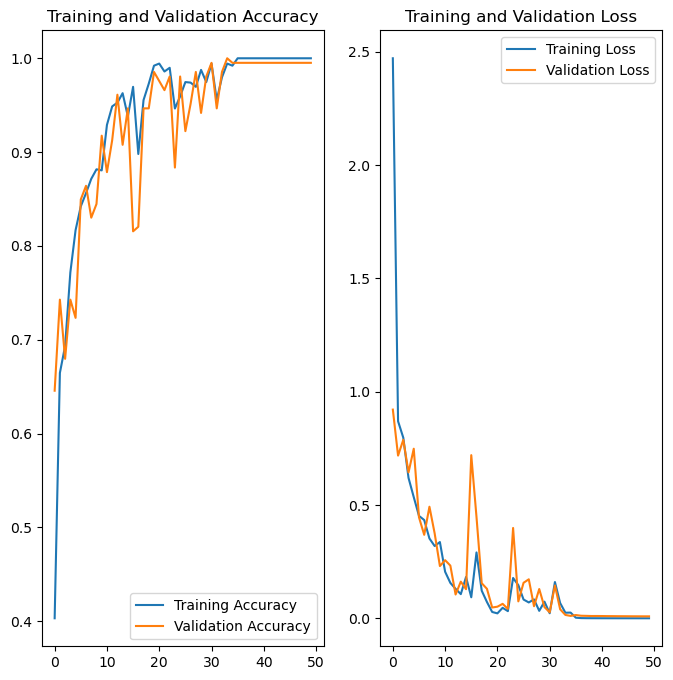

In [45]:
plt.figure(figsize = (8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

# Make Predictions / inferences on sample images

First image to predict: 
First image actual label:   Leaf_Scald
1/1 [==============================] - 0s 309ms/step
Batch Prediction:  Narrow_Brown_Spot


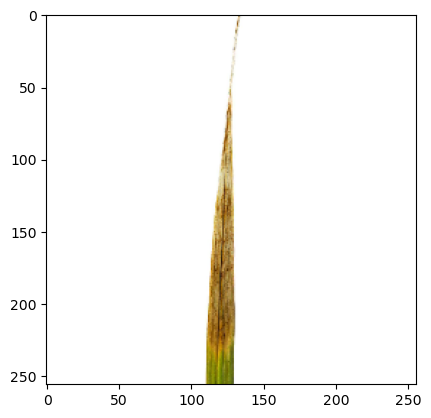

In [46]:
for images_batch, labels_batch in test_ds.take(1):
    #first_image = print(images_batch[0].numpy().astype('uint8'))
    # plt.imshow(images_batch[0].numpy().astype('uint8'))
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print('First image to predict: ')
    plt.imshow(first_image)
    print('First image actual label:  ' ,class_names[first_label])
    plt.imshow(first_image)
    
    batch_predicion  = model.predict(image_batch)
    print("Batch Prediction: ", class_names[np.argmax(batch_predicion[0])])

In [47]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    cofidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, cofidence

1/1 [==============================] - 0s 17ms/step


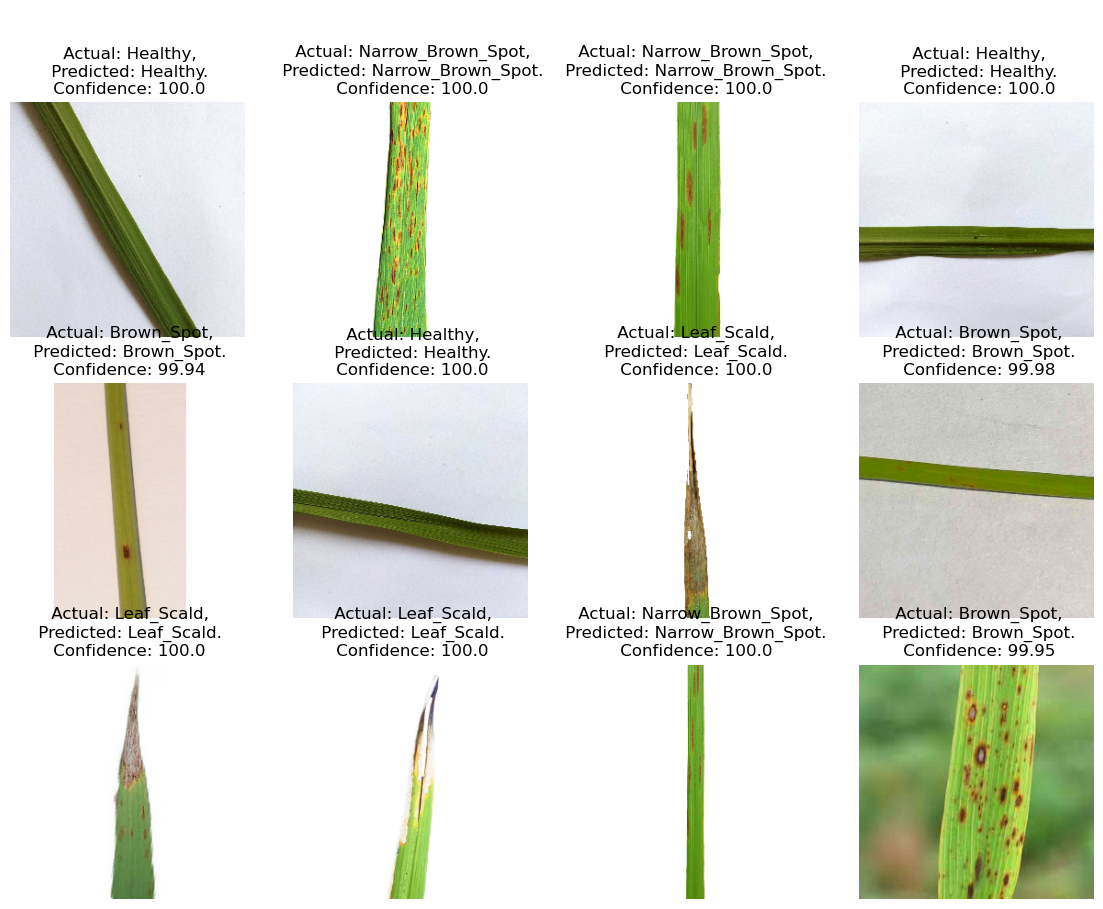

In [48]:
plt.figure(figsize=(14, 14))

for images, labels in test_ds.take(1):  # Corrected variable name 'lables' to 'labels'
    for i in range(12):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        ax.set_title(f"\n\n Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}")  # Corrected 'plot' to 'ax'
        plt.axis("off")
        
plt.show()

In [53]:
import os

# Get a list of files in the directory
model_dir = "../models"
files_in_dir = os.listdir(model_dir)


model_versions = [int(i) for i in files_in_dir if i.isdigit()]

latest_model_version = max(model_versions, default=0)

model_version = latest_model_version + 1

model.save(f"{model_dir}/{model_version}")


INFO:tensorflow:Assets written to: ../models/2/assets


INFO:tensorflow:Assets written to: ../models/2/assets


In [ ]:
# import os
# model_version = max([int(i) for i in os.listdir("../models") + [0]]) + 1
# model.save(f"../models/{model_version}")

In [ ]:
#model_version = 1
#model.save(f"../models/{model_version}")

#### Load the model

In [54]:
new_model = create_model()
new_model = tf.keras.models.load_model('../models/2')